In [15]:
from langchain.schema import Document
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_community.vectorstores import Chroma

embedding_function = GoogleGenerativeAIEmbeddings(model="models/embedding-001")


docs = [
   Document(
        page_content="Travories is a travel booking platform where travel agencies can create and list their tour packages. Tourists can browse and book these packages directly through the platform. Travories aims to connect travelers with a wide variety of curated travel experiences.",
        metadata={"source": "overview.txt"}
    ),
    Document(
        page_content="Travories is accessible 24 hours a day, 7 days a week, allowing both agencies and tourists to use the platform at their convenience, regardless of their time zone.",
        metadata={"source": "availability.txt"}
    ),
    Document(
        page_content="Travel agencies on Travories have the ability to create detailed descriptions of their tour packages, including itineraries, pricing, inclusions, and stunning visuals. They manage their own listings and availability.",
        metadata={"source": "agency_features.txt"}
    ),
    Document(
        page_content="Tourists using Travories can search for travel packages based on destination, interests, duration, and budget. They can view package details, read reviews (if available), and securely book their chosen tours through the platform.",
        metadata={"source": "tourist_features.txt"}
    ),
    Document(
        page_content="For any inquiries or support, users can contact Travories customer support via email at support@travories.com or through the live chat feature available on the website and mobile app.",
        metadata={"source": "support.txt"}
    ),
    Document(
        page_content="Travories supports various payment methods, including major credit cards, debit cards, and popular online payment gateways, ensuring a seamless booking experience for tourists worldwide.",
        metadata={"source": "payment.txt"}
    )
]

db = Chroma.from_documents(docs, embedding_function)


In [16]:
retriever = db.as_retriever(search_type="mmr", search_kwargs = {"k": 3})


In [17]:
from langchain.tools.retriever import create_retriever_tool
from langchain_core.tools import tool

retriever_tool = create_retriever_tool(
    retriever,
    "retriever_tool",
    "Information related to Travories' Overview, Platform Availability, Travel Agency Features, Tourist Features, Customer Support, and Payment Options."
)



@tool
def off_topic():
    """Catch all questions NOT related to Travories' overview, platform availability, travel agency tools, tourist features, customer support, or payment methods."""
    return "Forbidden - do not respond to the user"


tools = [retriever_tool, off_topic]

In [18]:
from typing import Annotated,Sequence, Literal, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [20]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import END, StateGraph, START


def agent(state):
    messages = state["messages"]
    model = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    return {"messages": [response]}


def should_continue(state) -> Literal["tools", END]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [21]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

workflow = StateGraph(AgentState)

workflow.add_node("agent", agent)

tool_node = ToolNode(tools)
workflow.add_node("tools", tool_node)
workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", "agent")

graph = workflow.compile()

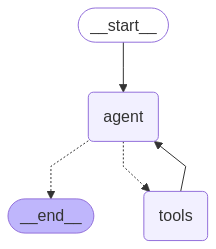

In [22]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [23]:
graph.invoke(
    input={"messages": [HumanMessage(content="How will the weather be tommorrow?")]}
)

{'messages': [HumanMessage(content='How will the weather be tommorrow?', additional_kwargs={}, response_metadata={}, id='731ac633-0844-4fe5-9214-4f6d5f3e17e1'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'off_topic', 'arguments': '{}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--8f4fc604-536a-405d-b274-abd0ceb1851e-0', tool_calls=[{'name': 'off_topic', 'args': {}, 'id': '0904db06-31dc-4e1b-87ce-1efa2e4a7b82', 'type': 'tool_call'}], usage_metadata={'input_tokens': 78, 'output_tokens': 3, 'total_tokens': 81, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='Forbidden - do not respond to the user', name='off_topic', id='839a9049-a33f-41a3-aa84-92d831b2de5c', tool_call_id='0904db06-31dc-4e1b-87ce-1efa2e4a7b82'),
  AIMessage(content='I am sorry, I cannot answer this question.  My knowledge about weather is limited.', additional_kwargs={}, response_metada

In [24]:
graph.invoke(input={
    "messages": [HumanMessage(content="Is Travories open all the time?")]
})

{'messages': [HumanMessage(content='Is Travories open all the time?', additional_kwargs={}, response_metadata={}, id='0fa7fda3-9d3e-446a-848b-d2a9f683bdc7'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'retriever_tool', 'arguments': '{"query": "Travories\'s platform availability"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--3ab735b6-e224-4a9d-9bfa-c55afb5f9ad1-0', tool_calls=[{'name': 'retriever_tool', 'args': {'query': "Travories's platform availability"}, 'id': 'bce439d4-c5ea-4922-86db-1db1ad808f43', 'type': 'tool_call'}], usage_metadata={'input_tokens': 78, 'output_tokens': 11, 'total_tokens': 89, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='Travories is accessible 24 hours a day, 7 days a week, allowing both agencies and tourists to use the platform at their convenience, regardless of their time zone.\n\nFor any inquiries or support, users